## Sequential Data Prediction using RNN
#### Going to predict using trig functions

In [205]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [257]:
t = np.arange(0, 2000, 0.1); print(len(t))

20000


In [282]:
def trig_function(t):
    temp_sin = 3 * np.power(np.sin(t),9)
    temp_cos = 2 * np.power(np.cos(t),9)
    r = np.random.rand(len(t))
    return temp_sin + temp_cos + r

In [283]:
trig_data_original = trig_function(t)

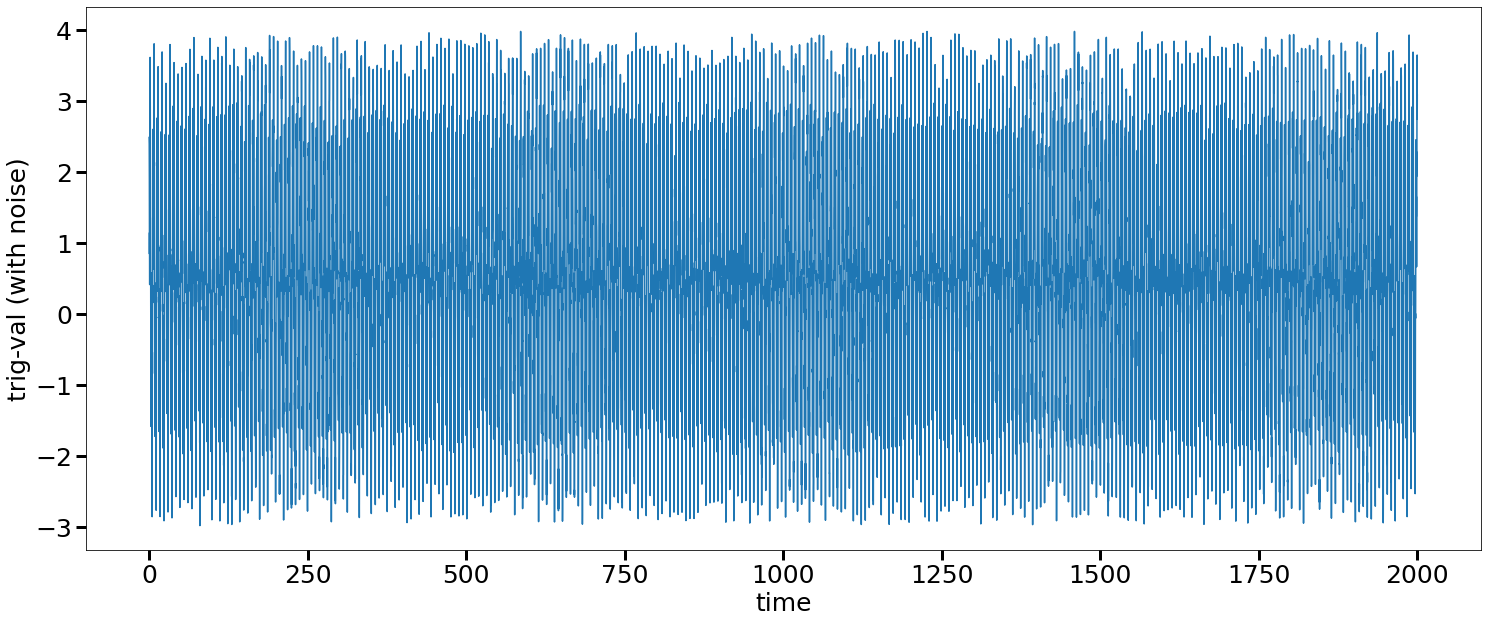

In [284]:
plt.figure(figsize=(25,10))
#plt.scatter(t, trig_data, marker='x')
plt.plot(t, trig_data_original)
plt.tick_params(axis='both', which='major', labelsize=25,length=10,width=3)
plt.xlabel(xlabel='time', size='25')
plt.ylabel(ylabel='trig-val (with noise)', size='25')
plt.show()

## Single Step Model: Predicts One data point into future

### Making appropriate training, testing data

> probably the most important part out of all this.

In [285]:
trig_data = np.copy(trig_data_original)

In [286]:
trig_series = pd.Series(data=trig_data, index=t, name="Trig Data")
train_end_index = int(len(trig_series) * 0.8); train_end_index

16000

In [287]:
# this code is directly from https://www.tensorflow.org/tutorials/structured_data/time_series

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    
  return np.array(data), np.array(labels)

In [288]:
# time to scale these features and standardize using training data

train_data_mean = trig_data[:train_end_index].mean()
train_data_std = trig_data[:train_end_index].std()
print(train_data_mean, train_data_std)
trig_data = (trig_data - train_data_mean)/train_data_std

0.49673052786823746 1.582014222923701


In [289]:
# choose {trig_past_history} vals to use to predict {trig_future_target + 1} vals into the future
trig_past_history = 75
trig_future_target = 0

x_train_trig, y_train_trig = univariate_data(trig_data, 0, train_end_index, trig_past_history, trig_future_target)

x_val_trig, y_val_trig = univariate_data(trig_data, train_end_index, None, trig_past_history, trig_future_target)

In [290]:
print(x_train_trig.shape, y_train_trig.shape)
print(x_train_trig.shape[-2:])

(15925, 75, 1) (15925,)
(75, 1)


In [291]:
print(x_val_trig.shape, y_val_trig.shape)

(3925, 75, 1) (3925,)


Past history example:
 [[ 1.26023519]
 [ 1.21653192]
 [ 1.20301155]
 [ 1.04900575]
 [ 0.88233155]
 [ 0.36761148]
 [ 0.22129236]
 [ 0.41142698]
 [ 0.0232057 ]
 [-0.05180649]
 [ 0.69075598]
 [ 0.90919136]
 [ 1.28298929]
 [ 1.15100921]
 [ 1.44646159]
 [ 1.54499082]
 [ 1.97427652]
 [ 1.86030413]
 [ 1.55786469]
 [ 0.97262829]
 [ 0.95033984]
 [ 0.30775924]
 [ 0.43760724]
 [ 0.27617543]
 [-0.0161477 ]
 [-0.03648306]
 [-0.2265727 ]
 [-0.62038823]
 [-0.59869213]
 [-1.13213675]
 [-1.31674784]
 [-1.09512551]
 [-1.11599242]
 [-1.23506012]
 [-1.21585558]
 [-0.38595682]
 [-0.48446679]
 [-0.60480077]
 [ 0.0503222 ]
 [-0.36322735]
 [-0.08878739]
 [-0.47366539]
 [-0.79695696]
 [-1.10435198]
 [-1.06961895]
 [-1.26746369]
 [-2.07226695]
 [-1.93868639]
 [-2.12190282]
 [-1.52488675]
 [-1.46313712]
 [-0.65528534]
 [-0.84500456]
 [-0.12181673]
 [-0.05636661]
 [-0.21461359]
 [ 0.34278664]
 [ 0.5452832 ]
 [ 0.20855073]
 [ 0.80683681]
 [ 1.02227827]
 [ 1.3332144 ]
 [ 1.08874979]
 [ 1.06368276]
 [ 1.11696229]
 [

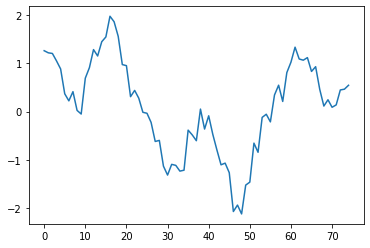

In [292]:
print("Past history example:\n", x_train_trig[0])
print("using this history to predict the val: ", y_train_trig[0])
plt.plot(x_train_trig[0])

In [294]:
# much of below code is derived from https://www.tensorflow.org/tutorials/structured_data/time_series

BATCH_SIZE = 300
BUFFER_SIZE = 10000

train_trig = tf.data.Dataset.from_tensor_slices((x_train_trig, y_train_trig))
train_trig = train_trig.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_trig = tf.data.Dataset.from_tensor_slices((x_val_trig, y_val_trig))
val_trig = val_trig.batch(BATCH_SIZE).repeat()

In [295]:
# creating the neural network model

lstm_prediction_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_trig.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [296]:
lstm_prediction_model.compile(optimizer='adam', loss='mae')

In [298]:
lstm_prediction_model.fit(train_trig, epochs=10, steps_per_epoch=250, validation_data=val_trig, validation_steps=50)

Train for 250 steps, validate for 50 steps
Epoch 1/10
 81/250 [========>.....................] - ETA: 20s - loss: 0.1706

KeyboardInterrupt: 

In [299]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

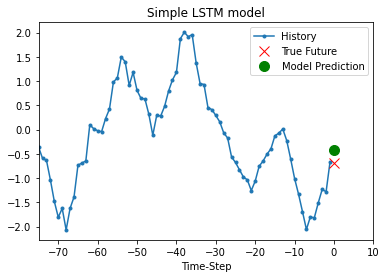

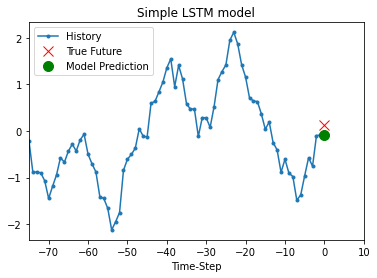

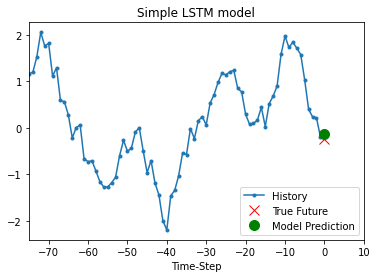

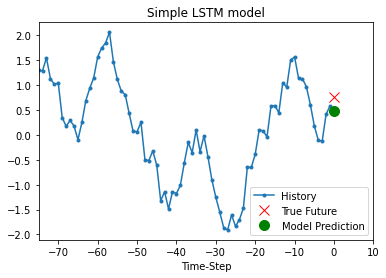

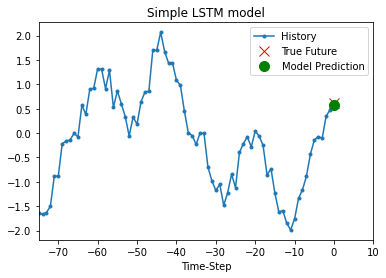

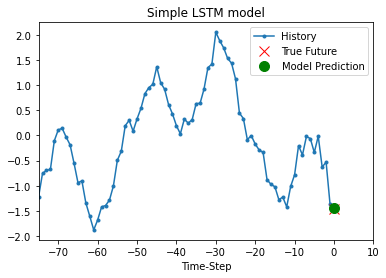

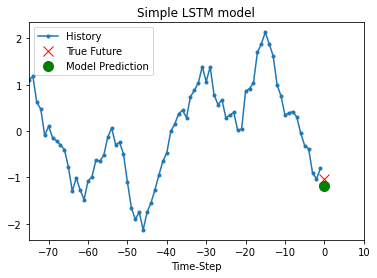

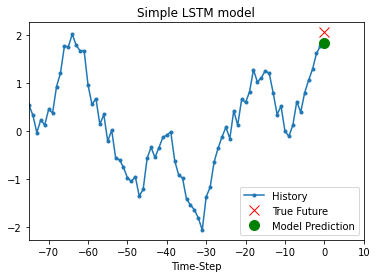

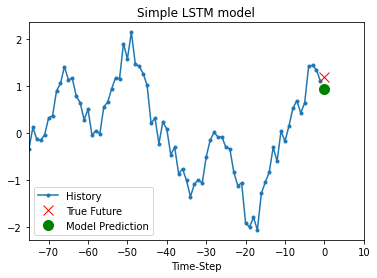

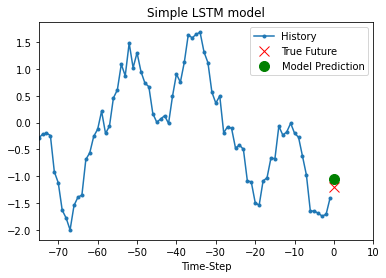

In [300]:
for x, y in val_trig.take(10):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    lstm_prediction_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()